# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings
warnings.filterwarnings('always')
import shapely.speedups
from IPython.display import Image
import re
from itertools import combinations
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()

In [3]:
viviendas = pd.concat([viviendas_train, viviendas_test]).reset_index()

# 1.Procesamiento del Lenguaje Natural

## a) Ampliación del dataset

In [4]:
veces_palabra = {}
indice_de_palabra = {}
for indice in viviendas.index:
    property_title = viviendas.loc[indice,:].property_title.lower()

    if "/" in property_title:
        property_title = property_title.replace("/"," ")
    if "." in property_title:
        property_title = property_title.replace("."," ")
    if "," in property_title:
        property_title = property_title.replace(","," ")
    if "-" in property_title:
        property_title = property_title.replace("-"," ")
    if "ó" in property_title:
        property_title = property_title.replace("ó","o")
    if "!" in property_title:
        property_title = property_title.replace("!"," ")

    property_title = property_title.split()
    
    for palabra in property_title:
        palabra = ''.join(char for char in palabra if char.isalnum())
        if palabra.isnumeric() or len(palabra) < 3:
            continue
        veces_palabra[palabra] = veces_palabra.get(palabra, 0)
        veces_palabra[palabra] +=1 

        indice_de_palabra[palabra]  = indice_de_palabra.get(palabra, list())
        indice_de_palabra[palabra].append(indice)


In [5]:
def agregar_aspecto(aspecto, palabras_clave, dataset):
    for palabra in indice_de_palabra.keys():
        for palabra_clave in palabras_clave:
            if palabra_clave in palabra:
                for i in indice_de_palabra[palabra]:
                    dataset.loc[i, aspecto] = 'sí'
    dataset[aspecto].fillna('unknown', inplace=True)

    
    print(f'cantidad de {aspecto}: { (dataset[aspecto] == "sí").sum() }')

In [6]:
palabras_a_ignorar = set(['departamento', 'depto', 'casa', 'ph', 'venta', 'amb', 'ambientes', 'con'])
for barrio in viviendas_train.barrio:
    for t in barrio.split():
        palabras_a_ignorar.add(t.lower())
for palabra in palabras_a_ignorar:
    if palabra in veces_palabra:
        veces_palabra.pop(palabra)
        indice_de_palabra.pop(palabra)

Ordenamos palabras por cantidad de apariciones para buscar posibles aspectos que sumen valor a nuestro dataset

In [7]:
sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1]
print((sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1])[:50]) #CAMBIE

[('balcon', 12291), ('cochera', 10563), ('monoambiente', 7156), ('terraza', 6564), ('estrenar', 5194), ('patio', 5062), ('amenities', 4632), ('luminoso', 4596), ('excelente', 4338), ('piso', 4099), ('frente', 3789), ('oportunidad', 3193), ('parrilla', 2833), ('apto', 2625), ('muy', 2595), ('vista', 2404), ('dependencia', 2223), ('baulera', 2121), ('semipiso', 1953), ('dpto', 1933), ('dos', 1826), ('reciclado', 1804), ('expensas', 1801), ('alto', 1796), ('hermoso', 1783), ('duplex', 1759), ('torre', 1724), ('profesional', 1713), ('dep', 1584), ('impecable', 1473), ('nuevo', 1445), ('coch', 1428), ('ambiente', 1423), ('hollywood', 1397), ('amplio', 1322), ('pozo', 1300), ('ubicacion', 1216), ('cocheras', 1198), ('propia', 1171), ('dormitorios', 1169), ('edificio', 1135), ('sin', 1125), ('pileta', 1086), ('gran', 1073), ('retasado', 977), ('tipo', 963), ('divisible', 927), ('chico', 923), ('abierta', 923), ('zona', 906)]


Viendo lo anterior buscamos aspectos importantes y palabras claves que los identifiquen para agregarlos al dataset:

+ A estrenar/nuevo
+ Patio/Jardin
+ balcon
+ cochera
+ pileta

In [8]:
agregar_aspecto('a_estrenar', ['estrenar', 'nuevo'], viviendas)
agregar_aspecto('patio_jardin', ['pat', 'jard'], viviendas)
agregar_aspecto('balcon', ['balc'], viviendas)
agregar_aspecto('cochera', ['coche', 'garag'], viviendas)
agregar_aspecto('pileta', ['pil', 'pisc'], viviendas)
agregar_aspecto('parrilla', ['parr'], viviendas)
agregar_aspecto('terraza', ['terra'], viviendas)
agregar_aspecto('monoambiente', ['mono'], viviendas)

cantidad de a_estrenar: 6634
cantidad de patio_jardin: 6569
cantidad de balcon: 12821
cantidad de cochera: 12375
cantidad de pileta: 1842
cantidad de parrilla: 3048
cantidad de terraza: 7517
cantidad de monoambiente: 8109


In [9]:
viviendas

,index,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,...,property_title,geometry,a_estrenar,patio_jardin,balcon,cochera,pileta,parrilla,terraza,monoambiente
0,0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,...,Departamento - Saavedra,POINT (-58.4905135 -34.5550487),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,...,Departamento - Saavedra,POINT (-58.4785532 -34.546991),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
2,2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,...,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
3,3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,...,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
4,4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,...,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92874,18571,2021-02-13,2021-03-01,-34.594510,-58.413521,Barrio Norte,Departamento,3.0,2.0,60.0,...,VENTA DEPARTAMENTO 3 AMBIENTES BALCÓN FRENTE 3...,POINT (-58.413521 -34.59451),unknown,unknown,sí,unknown,unknown,unknown,unknown,unknown
92875,18572,2021-08-20,2200-12-31,-34.540767,-58.466694,Nuñez,Casa,4.0,3.0,210.0,...,Casa - Nuñez,POINT (-58.4666936 -34.5407667),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
92876,18573,2021-09-08,2021-10-14,-34.586723,-58.402579,Recoleta,Departamento,2.0,1.0,35.0,...,Recoleta 2 amb Oportunidad,POINT (-58.4025792 -34.5867234),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
92877,18574,2021-01-12,2021-06-05,-34.579607,-58.489898,Villa Urquiza,Departamento,4.0,3.0,76.0,...,4 ambientes al contrafrente con balcón y coche...,POINT (-58.4898982 -34.579607),unknown,unknown,sí,sí,unknown,unknown,unknown,unknown


## b) Modelos

### Preprocesamiento

In [10]:
viviendas.loc[:,"a_estrenar"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"patio_jardin"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"balcon"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"cochera"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"pileta"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"parrilla"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"terraza"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"monoambiente"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)

In [11]:
viviendas_train, viviendas_test = train_test_split(viviendas, test_size=0.2, random_state=2)
x_train_ampliado = viviendas_train[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]
x_test_ampliado = viviendas_test[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]

y_train_ampliado = viviendas_train.property_price
y_test_ampliado = viviendas_test.property_price

In [12]:
scaler = MinMaxScaler() 
x_train_ampliado = scaler.fit_transform(x_train_ampliado)
x_test_ampliado = scaler.transform(x_test_ampliado)

### Utilizando los mismos hiperparámetros seleccionados en el TP 1

In [13]:
"""
rand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')
rand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')
"""

"\nrand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')\nrand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')\n"

In [14]:
rand_xgb_ampliado_params_tp1 = joblib.load('./Models/xgb_ampliado_params_tp1')
best_xgb_regressor_ampliado_params_tp1 = rand_xgb_ampliado_params_tp1.best_estimator_

In [15]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_regressor_ampliado_params_tp1.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9107357812035757
Coef. de Determinación R2 ajustado: 0.9107165546204522
El error (mse) de test es: 7961554870.09518
El error (rmse) de test es: 89227.54546716603


Vemos que las metricas con el dataset ampliado mejoran considerablemente en comparacion con las del dataset sin ampliar.  
  
  Metricas sin ampliar:  
+    Coef. de Determinación R2: 0.9019645365048344  
+    Coef. de Determinación R2 ajustado: 0.9019434206869473  
+    El error (mse) de test es: 9168434434.619144  
+    El error (rmse) de test es: 95751.94219763453  

In [16]:
def porcentaje_de_cambio_de_metricas(nombre_metrica, metrica_nueva, metrica_anterior):
    porcentaje = round(metrica_nueva*100/ metrica_anterior -100,3)
    if nombre_metrica == 'R2' or 'R2 ajustado':
        if porcentaje < 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')

    elif nombre_metrica == 'RMSE' or 'MSE':
        if porcentaje > 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')


Cambio de métricas respecto al dataset sin ampliar (con mismos hiperparametros):

In [17]:
porcentaje_de_cambio_de_metricas('R2', 0.9107357812035757, 0.9019645365048344)
porcentaje_de_cambio_de_metricas('RMSE', 89227.54546716603, 95751.94219763453 )

la metrica R2 es un 0.972% mejor
la metrica RMSE es un 6.814% peor


### Utilizando hiperparametros optimizados con el nuevo dataset ampliado.

decidimos usar GridSearchCV, porque usando RandomSearchCV no obteníamos hiperparámetros distintos a los del dataset sin ampliar

In [18]:
"""#Grilla de Parámetros
params_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

#Clasificador KNN
xgb_regressor_ampliado = xgb.XGBRegressor()

grid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')

grid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')
"""

"#Grilla de Parámetros\nparams_grid = {\n    'n_estimators': [100, 400, 800],\n    'max_depth': [3, 6, 9],\n    'learning_rate': [0.05, 0.1, 0.20],\n    'min_child_weight': [1, 10, 100]\n    }\n\n#Clasificador KNN\nxgb_regressor_ampliado = xgb.XGBRegressor()\n\ngrid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')\n\ngrid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')\n"

In [19]:
grid_xgb_ampliado_param_tp2 = joblib.load('./Models/grid_xgb_ampliado_param_tp2')
best_xgb_ampliado_param_tp2 = grid_xgb_ampliado_param_tp2.best_estimator_

In [20]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_ampliado_param_tp2.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 12 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9127994404557074
Coef. de Determinación R2 ajustado: 0.912743069895209
El error (mse) de test es: 7777495270.509185
El error (rmse) de test es: 88190.10868861193


In [21]:
performance_train = pd.DataFrame({'Valor Real': y_test_ampliado,
                            'Prediccion': y_pred_test_xgb.round(),
                            'Error': y_test_ampliado - y_pred_test_xgb.round()})
performance_train.head()

,Valor Real,Prediccion,Error
63184,69900.0,78191.0,-8291.0
62628,108000.0,143328.0,-35328.0
75408,75000.0,104908.0,-29908.0
49022,420000.0,675072.0,-255072.0
29265,49900.0,56399.0,-6499.0


c:\Users\iankl\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1080: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)
c:\Users\iankl\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


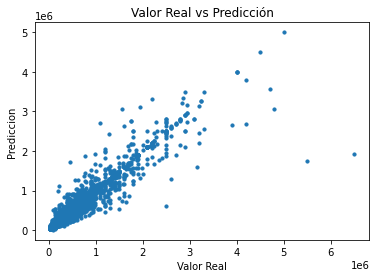

In [22]:
scatter_real_predict_train = performance_train.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


Cambio de métricas buscando nuevos hiperparametros

In [23]:
porcentaje_de_cambio_de_metricas('R2', 0.9127994404557074, 0.9107357812035757)
porcentaje_de_cambio_de_metricas('RMSE', 88190.10868861193, 89227.54546716603)

la metrica R2 es un 0.227% mejor
la metrica RMSE es un 1.163% peor


# 4. Conclusiones

### opciones que hubiesemos explorado y quedaron fuera del alcance de este trabajo

+ En cuanto a la primera parte (Ampliación del dataset), se pudo haber usado algun métodos de extracción de conocimiento como lo son ExtrHech, ArgOE, DepOE o ECMes. También se pudieron haber añadido al dataset columnas como cantidad de baños o expensas las cuales tendrían valores extraídos del texto de property_title.

+ En cuanto a la segunda parte (Redes Neuronales), se pudo haber probado una grilla con mayor cantidad de hiperparámetros, como por ejemplo reguladores (L1 y L2), early stopping y dropout. Tambien podríamos haber probado otras distintas combinaciones de capas ocultas de neuronas además de probar otro tipo de capas. Se pudo haber probado correr más iteraciones mezclando hiperparámetros.
Otra cosa que quedó fuera de nuestro alcance es hacer un ensamble entre nuestros mejores modelos de redes

+ En cuanto a la tercera parte podríamos haber usado para los ensambles algunos de nuestros modelos de redes




### Aspectos relevantes:

+ Parte 1: Procesamiento de Lenguaje Natural
  + Para elegir las nuevas columnas buscamos las palabras con más apariciones ordenadas de mayor a menor, y luego elegimos algunas de estas palabras que creímos que aportaban valor.
  + La ampliación del dataset contribuyó a mejorar el resultado de XGBoost pero al volver a buscar "mejores hiperparametros" llegamos prácticamente a lo mismo, ya que creemos que las nuevas columnas no agregan suficiente informacion como para conseguir mejores métricas con distintos hiperparametros. 
  + Dado las mejoras en los resultados de XGBoost concluimos que nuestras nuevas columnas sí aportan valor al dataset original, lo que es lógico por su naturaleza. Por ejemplo la columna "a_estrenar" aporta mucho valor, ya que no es lo mismo una vivienda nueva que usada.  
<br />
    
+ Parte 2: Redes Neuronales  
  + Corrimos muchos modelos de redes con diferentes combinaciones de hiperparametros sobre datasets reducidos y seleccionamos los que daban mejores resultados, y los corrimos sobre el dataset completo para así quedarnos con el mejor modelo.
  + Los resultados obtenidos no cumplieron las espectativas (ni en regresion ni en clasificacion) ya que los modelos utilizados en el TP1 dieron mejores métricas
  + Creemos que esto se puede deber a varios motivos:
    + Mala seleccion de hiperparametros y capas
    + Mala adaptacion de las redes a nuestrio problema

<br /> 

+ Parte 3: Ensambles de Modelos
  + 
  + 
  + 
  